## Check whether PyTorch and TensorFlow preprocessings are match

In [24]:
import os
from pathlib import Path
import sys

import lightning
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import yaml

ROOT = Path.cwd().parent
sys.path.append(str(ROOT))

from src.lightning import LitDataModule

np.set_printoptions(
    linewidth=np.inf,
    threshold=np.inf,
    suppress=True,  # avoid scientific notation for small numbers
    formatter={'float_kind': lambda x: f"{x:.5f}"}
)

In [2]:
'''Change the hyperparameters here'''
data_mode = 'jet_flavor'  # 'jet_flavor' or 'supervised'
data_format = 'image'     # 'image' or 'sequence'
luminosity = 100         # change the luminosity here
decay_channel = 'diphoton'    # 'zz4l' or 'diphoton'
with open(ROOT / 'config' / f"data_{decay_channel}.yml", 'r') as f:
    data_info = yaml.safe_load(f)


# data setup
for include_decay in [True, False]:
    
    lightning.seed_everything(123)
    
    lit_data_module = LitDataModule(
        batch_size=512,
        data_mode=data_mode,
        data_format=data_format,
        data_info=data_info,
        include_decay=include_decay,
        luminosity=luminosity,
    )

    prefix = f"w_{data_info['decay_channel']}" if include_decay else f"wo_{data_info['decay_channel']}"
    output = ROOT / 'data' / f"pt_{data_info['decay_channel']}" / f"{prefix}-{data_format}"
    os.makedirs(output, exist_ok=True)
    np.save(output / 'train_sig.npy', lit_data_module.train_sig.numpy())
    np.save(output / 'train_bkg.npy', lit_data_module.train_bkg.numpy())
    np.save(output / 'valid_sig.npy', lit_data_module.valid_sig.numpy())
    np.save(output / 'valid_bkg.npy', lit_data_module.valid_bkg.numpy())
    np.save(output / 'test_sig.npy', lit_data_module.test_sig.numpy())
    np.save(output / 'test_bkg.npy', lit_data_module.test_bkg.numpy())
    print()

Seed set to 123


[CWoLa-Log] [signal] two quark jet: sig region: 340 events
[CWoLa-Log] [signal] two quark jet: bkg region: 53 events
[CWoLa-Log] [background] two quark jet: sig region: 560 events
[CWoLa-Log] [background] two quark jet: bkg region: 562 events
[Data-Log] Training data: 720 signal events and 491 background events.
[Data-Log] Validation data: 180 signal events and 124 background events.
[Data-Log] Testing data: 10000 signal events and 10000 background events.


Seed set to 123



[CWoLa-Log] [signal] two quark jet: sig region: 340 events
[CWoLa-Log] [signal] two quark jet: bkg region: 53 events
[CWoLa-Log] [background] two quark jet: sig region: 560 events
[CWoLa-Log] [background] two quark jet: bkg region: 562 events
[Data-Log] Training data: 720 signal events and 491 background events.
[Data-Log] Validation data: 180 signal events and 124 background events.
[Data-Log] Testing data: 10000 signal events and 10000 background events.



In [33]:
def plot_image(pt_data, tf_data):
    # Plot two rows with PyTorch data and TensorFlow data
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))

    grid_size = 40
    phi_bins = np.linspace(-np.pi, np.pi, grid_size + 1)
    eta_bins = np.linspace(-5, 5, grid_size + 1)

    for i, (package, data) in enumerate([('PyTorch', pt_data), ('TensorFlow', tf_data)]):
        axs[i][0].set_title(f"{package} - TOWER")
        axs[i][1].set_title(f"{package} - TRACK")
        axs[i][2].set_title(f"{package} - DECAY")
        for j, image in enumerate(data):
            data_masked = np.ma.masked_where(image == 0, image)
            c = axs[i][j].pcolormesh(eta_bins, phi_bins, data_masked, norm=LogNorm(vmin=0.1, vmax=1e3), cmap='jet')
            axs[i][j].set_xlabel(r'$\eta$')
            axs[i][j].set_ylabel(r'$\phi$')
            fig.colorbar(c, ax=axs[i][j], label=r'$p_T$ [GeV]')

    plt.tight_layout()
    plt.show()

TF data shape: (20000, 3, 40, 40), PT data shape: (20000, 3, 40, 40)

Data index: 5588, Sum of absolute differences: 6.625078201293945
TensorFlow data (TF) [3.31254 0.00000]
PyTorch data (PT)    [0.00000 3.31254]


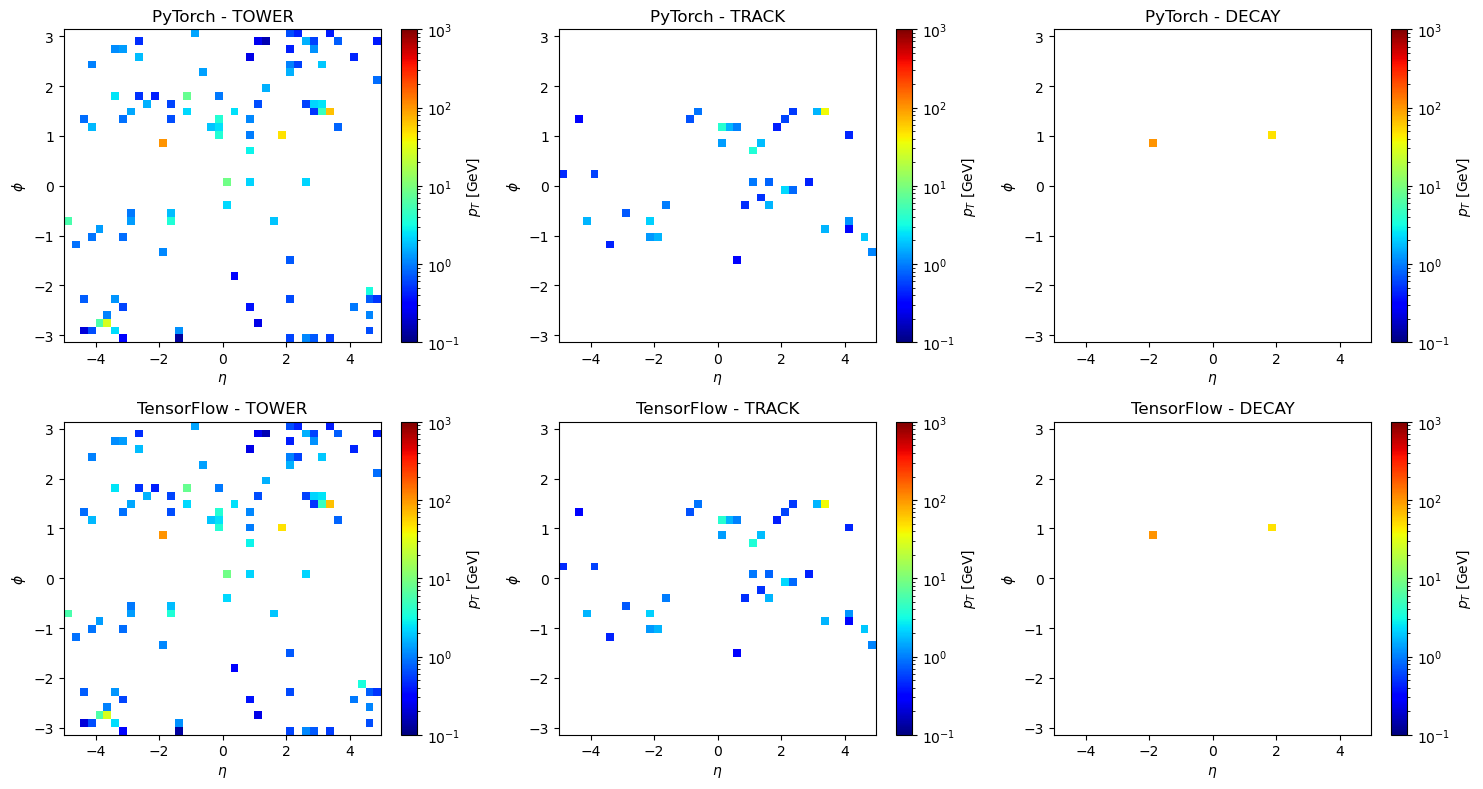


[L100][w_diphoton-image] Found 1 mismatched samples out of 20000

____________________________________________________________________________________________________

TF data shape: (20000, 2, 40, 40), PT data shape: (20000, 2, 40, 40)

Data index: 14, Sum of absolute differences: 0.98476642370224
TensorFlow data (TF) [0.98477]
PyTorch data (PT)    [0.00000]


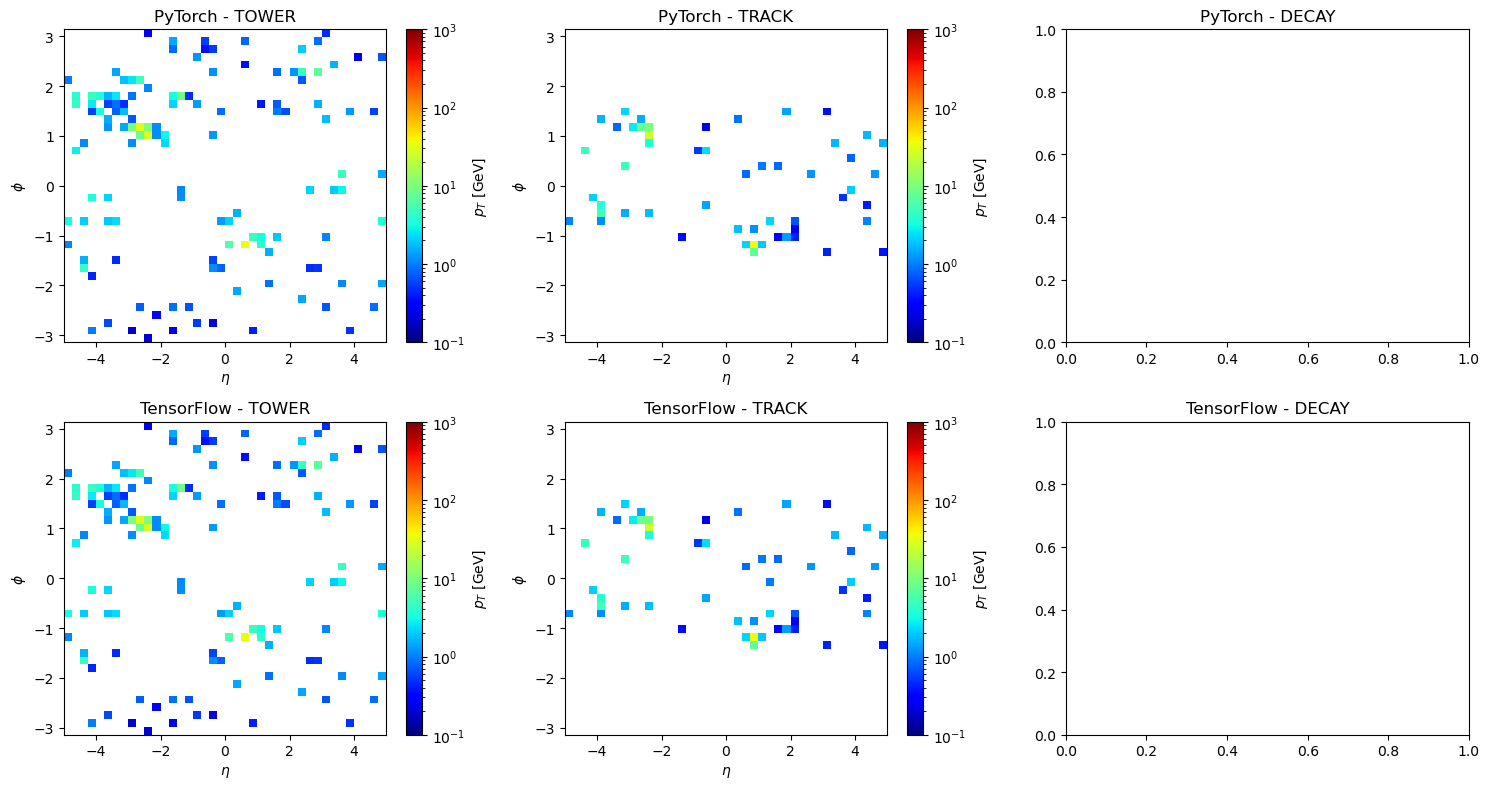


Data index: 42, Sum of absolute differences: 0.4794127941131592
TensorFlow data (TF) [0.47941]
PyTorch data (PT)    [0.00000]


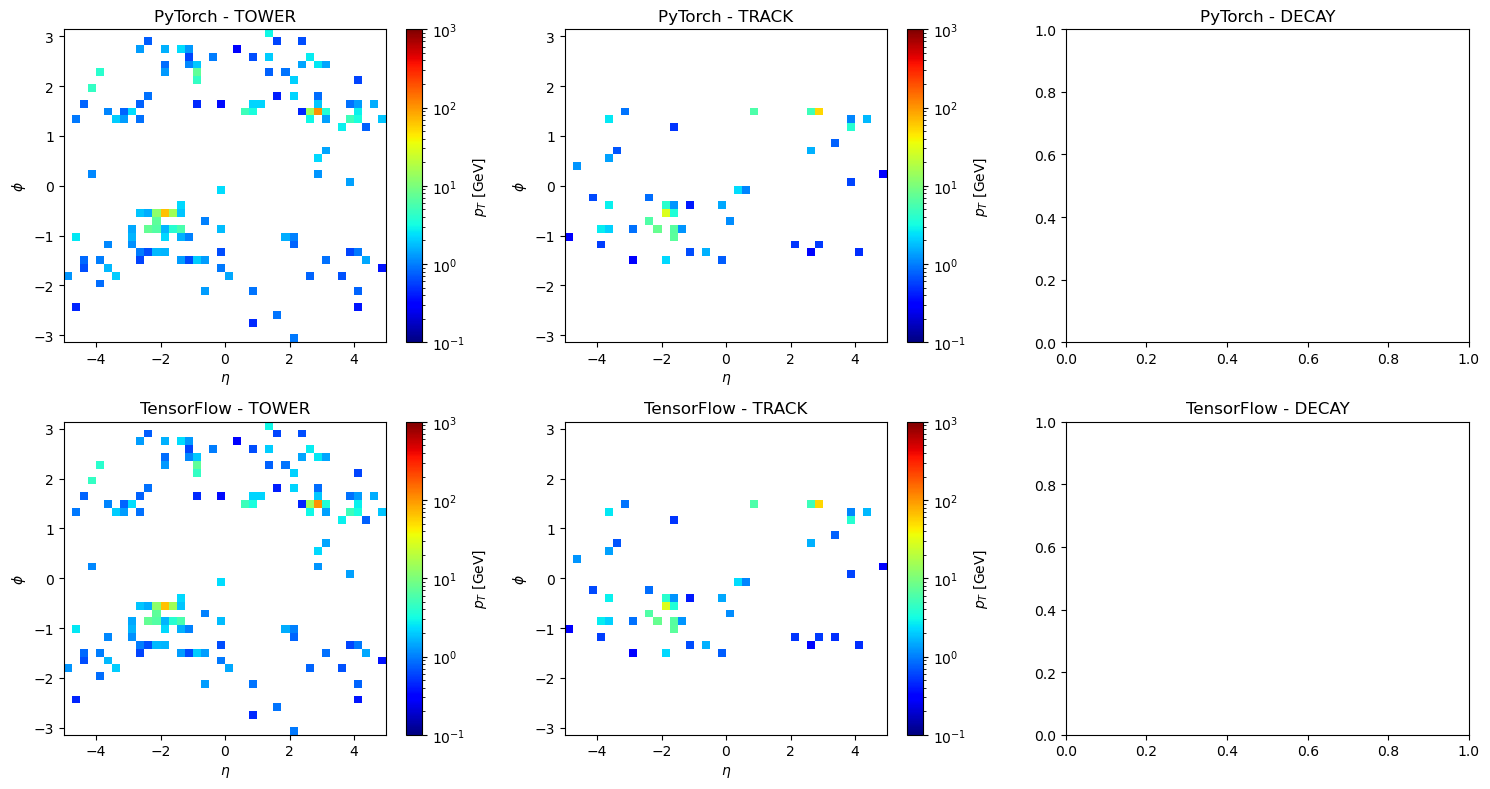


Data index: 61, Sum of absolute differences: 1.5150601863861084
TensorFlow data (TF) [1.51506]
PyTorch data (PT)    [0.00000]


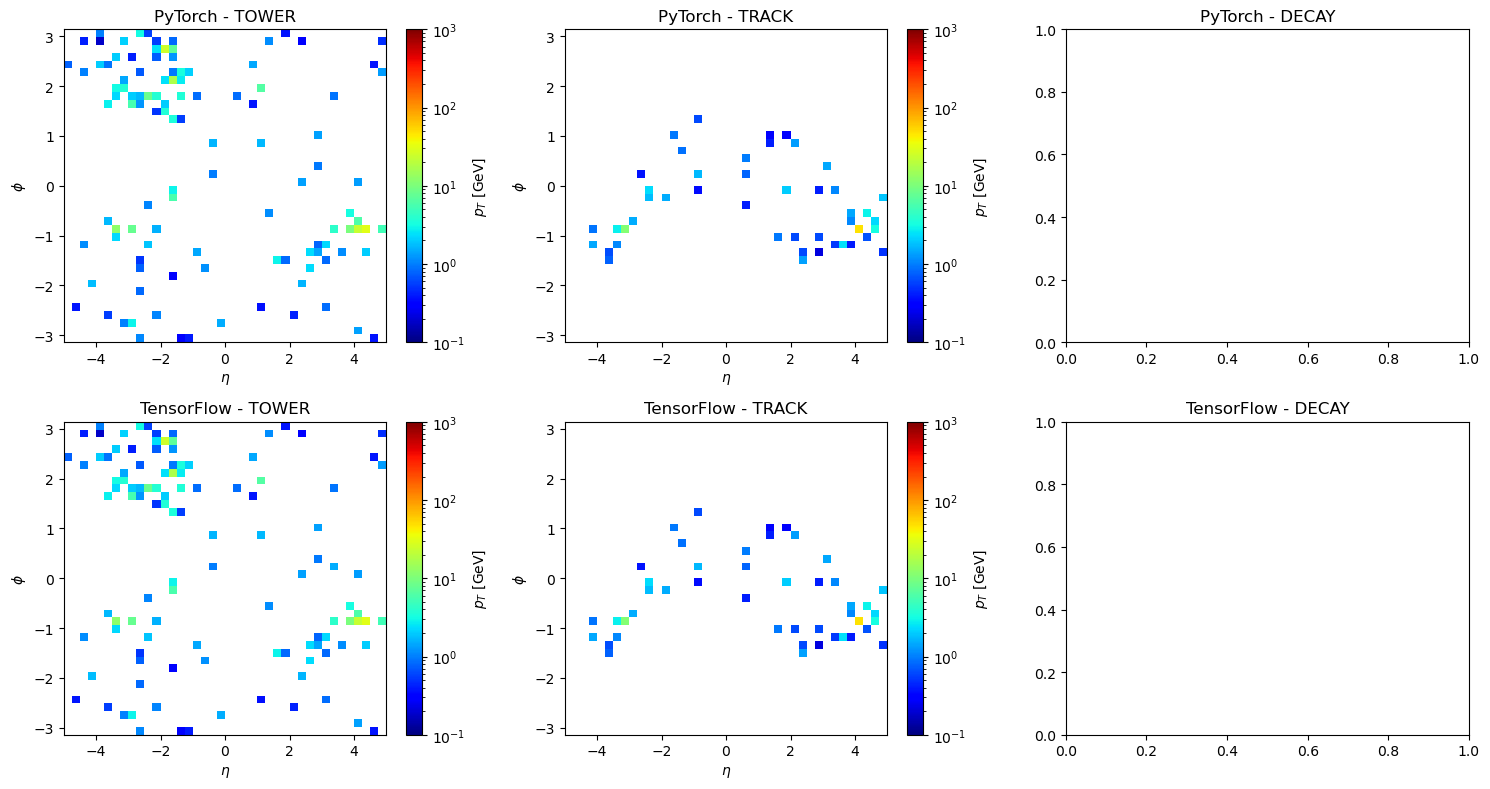


[L100][wo_diphoton-image] Found 2145 mismatched samples out of 20000

____________________________________________________________________________________________________



In [35]:
'''Change the hyperparameters here'''
L = 100
rnd_seed = 123
data_format = 'image'
decay_channel = 'diphoton'

for include_decay in [True, False]:

    channel_file = f"w_{decay_channel}" if include_decay else f"wo_{decay_channel}"
    channel_file += f"-{data_format}"

    # TensorFlow data
    tf_mode = 'test'
    tf_data = np.load(ROOT / 'data' / f"tf_{decay_channel}" / channel_file / f"L{L}_seed_{rnd_seed}" / f"X_{tf_mode}.npy")
    tf_data = tf_data.astype(np.float32)
    if data_format == 'image':
        tf_data = tf_data.transpose(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
    elif data_format == 'sequence':
        tf_data = np.nan_to_num(tf_data, nan=-1)

    # PyTorch data
    pt_mode = 'test'
    pt_path = ROOT / 'data' / f"pt_{decay_channel}" / channel_file
    pt_data = np.concatenate((np.load(pt_path / f"{pt_mode}_sig.npy"), np.load(pt_path / f"{pt_mode}_bkg.npy")), axis=0)
    pt_data = pt_data.astype(np.float32)
    if data_format == 'sequence':
        pt_data = np.nan_to_num(pt_data, nan=-1)

    # Make sure the data shapes are the same
    if data_format == 'image':
        print(f"TF data shape: {tf_data.shape}, PT data shape: {pt_data.shape}\n")
        assert tf_data.shape == pt_data.shape, f"Shape mismatch: {tf_data.shape} vs {pt_data.shape}"
    elif data_format == 'sequence':
        tf_data = tf_data[:, :400, :3]
        pt_data = pt_data[:, :400, :3]

    # Check the difference between TensorFlow and PyTorch data
    counter = 0
    for i in range(len(tf_data)):
        _tf_data, _pt_data = tf_data[i], pt_data[i]
        diff = np.abs(_tf_data - _pt_data)

        atol = 1e-5  # absolute tolerance
        if not np.allclose(_tf_data, _pt_data, atol=atol):
            if counter < 3:
                print(f"Data index: {i}, Sum of absolute differences: {np.sum(diff)}")
                print('TensorFlow data (TF)', _tf_data[diff > atol])
                print('PyTorch data (PT)   ', _pt_data[diff > atol])
                if data_format == 'image':
                    plot_image(_pt_data, _tf_data)
                print()
            counter += 1

    print(f"[L{L}][{channel_file}] Found {counter} mismatched samples out of {len(tf_data)}")
    print('\n' + '_' * 100 + '\n')